In [55]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from tqdm.auto import tqdm
import torch 
from torch import nn
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('data/chineseMNIST.csv')

In [3]:
df.sample(10)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
8359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,二
4196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10000,万
14747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
9962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,三
7976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,一
10350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,四
10553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,四
12282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,六
14460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,八
1080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,十


In [4]:
df.shape

(15000, 4098)

In [5]:
feature_vectors, labels = df.iloc[:, :-2], df.iloc[:, -2:]

In [6]:
feature_vectors.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
labels.value_counts()

label      character
0          零            1000
1          一            1000
2          二            1000
3          三            1000
4          四            1000
5          五            1000
6          六            1000
7          七            1000
8          八            1000
9          九            1000
10         十            1000
100        百            1000
1000       千            1000
10000      万            1000
100000000  亿            1000
Name: count, dtype: int64

In [8]:
one_hot = OneHotEncoder(sparse_output = False)

In [9]:
encoded_labels = one_hot.fit_transform(labels.iloc[:, :1].values)

In [10]:
np_features, np_targets = feature_vectors.values.astype(np.float32), encoded_labels.copy()

In [11]:
np_labels = labels.iloc[:, :1].values

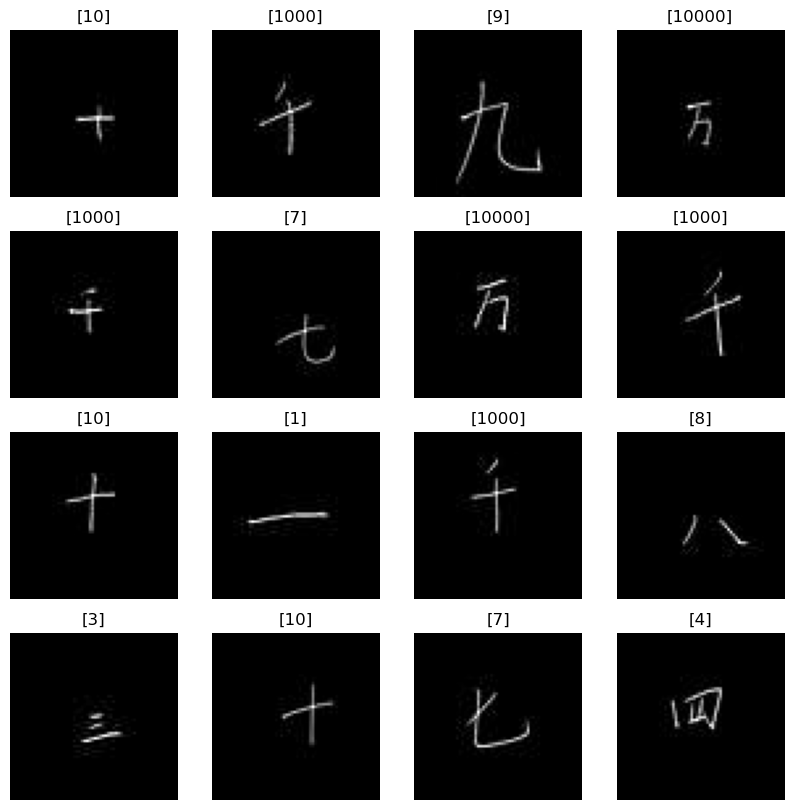

In [12]:
fig = plt.figure(figsize = (10, 10))

rows, cols = 4,4

for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    choice = random.randint(0, 14999)
    chosen_image = np_features[choice, :]
    chosen_label = np_labels[choice]
    plt.imshow(chosen_image.reshape(64, 64, 1), cmap = 'gray')
    plt.title(chosen_label)
    plt.axis(False)

In [13]:
class_names = np.unique(np_labels)
class_names

array([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,       100,
            1000,     10000, 100000000])

In [14]:
np_targets

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
np_target_features = np.array([i.reshape(1, 64, 64) for i in np_features])

In [16]:
torch_features = torch.tensor(np_target_features, dtype = torch.float)
torch_target = torch.tensor(np_targets)

In [17]:
torch_features.shape, torch_features.dtype, torch_target.shape

(torch.Size([15000, 1, 64, 64]), torch.float32, torch.Size([15000, 15]))

In [18]:
ds = TensorDataset(torch_features, torch_target)

In [19]:
train_ds, test_ds, val_ds = random_split(ds, [0.8, 0.1, 0.1])

In [20]:
len(train_ds), len(test_ds), len(val_ds)

(12000, 1500, 1500)

In [21]:
train_dl = DataLoader(dataset = train_ds, batch_size = 64, shuffle = True)
val_dl = DataLoader(dataset = val_ds, shuffle = False)
test_dl = DataLoader(dataset = test_ds, shuffle = False)

In [22]:
train_image_batch, train_image_label = next(iter(train_dl))

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [24]:
class ChineseMnistModelV0(nn.Module):
    def __init__(self, class_names):
        super(ChineseMnistModelV0, self).__init__()

        self.class_names = class_names
        
        self.input_layer = nn.Sequential(
            # input conv
            nn.Conv2d(1,128,2, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),
            nn.Dropout(0.3),
            # second conv
            nn.Conv2d(128,10,2, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2)),
            nn.Dropout(0.3),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(490, 150),
            nn.ReLU(),
            nn.Linear(150, out_features = self.class_names),
        )
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X /= 255
        X = self.input_layer(X)
        X = self.output(X)
        return X

In [25]:
model_0 = ChineseMnistModelV0(len(class_names)).to(device)

In [26]:
pred = model_0(train_image_batch[0].to(device, dtype = torch.float).unsqueeze(dim = 0))

In [27]:
train_image_batch[0].shape

torch.Size([1, 64, 64])

In [28]:
pred.shape

torch.Size([1, 15])

In [29]:
pred

tensor([[ 0.0525,  0.0855, -0.0815, -0.0765, -0.0295,  0.0321,  0.0226, -0.0548,
          0.0514, -0.0461,  0.0598,  0.0619,  0.0183, -0.0097,  0.0647]],
       grad_fn=<AddmmBackward0>)

In [30]:
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 1e-2, momentum = 0.9, weight_decay = 1e-4, nesterov = True)
loss_fn = nn.CrossEntropyLoss()

In [31]:
def fit(epochs, model, train_dl, test_dl, optimizer, loss_fn, device = 'cpu', step = 1):
    
    train_loss_count = list()
    test_loss_count = list()
    epoch_count = list()
    
    model.to(device)
    for epoch in tqdm(range(epochs)):

        train_loss = .0
        for X, y in train_dl:
            model.train()

            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dl)
        train_loss_count.append(train_loss.detach().item())

        test_loss = .0
        with torch.inference_mode():
            for test_X, test_y in test_dl:
                test_X, test_y = test_X.to(device), test_y.to(device)
                test_pred = model(test_X)

                test_loss += loss_fn(test_pred, test_y)

            test_loss /= len(test_dl)
            test_loss_count.append(test_loss.detach().item())

        epoch_count.append(epoch)
        if epoch % step == 0:
            print(f'Epoch: {epoch}')
            print(f'Train Loss -> {train_loss:.3f} | Test Loss -> {test_loss:.3f}')
            print('----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------')
        if epoch + 1 == epochs:
            print(f'Epoch: {epoch}')
            print(f'Train Loss -> {train_loss:.3f} | Test Loss -> {test_loss:.3f}')
            print('----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------')

    return {
    'epochs': epoch_count,
    'train_loss': train_loss_count,
    'test_loss': test_loss_count,
    }
        

In [32]:
torch.manual_seed(42)
history = fit(epochs = 50, model = model_0, train_dl = train_dl, test_dl = test_dl, optimizer = optimizer, loss_fn = loss_fn, step = 5)

  2%|▊                                        | 1/50 [02:07<1:44:19, 127.74s/it]

Epoch: 0
Train Loss -> 2.709 | Test Loss -> 2.710
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 12%|████▉                                    | 6/50 [12:19<1:29:54, 122.61s/it]

Epoch: 5
Train Loss -> 1.920 | Test Loss -> 1.765
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 22%|████████▊                               | 11/50 [21:34<1:14:04, 113.97s/it]

Epoch: 10
Train Loss -> 1.234 | Test Loss -> 1.309
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 32%|████████████▊                           | 16/50 [31:41<1:08:00, 120.01s/it]

Epoch: 15
Train Loss -> 0.939 | Test Loss -> 0.927
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 42%|█████████████████▋                        | 21/50 [41:53<59:28, 123.04s/it]

Epoch: 20
Train Loss -> 0.580 | Test Loss -> 0.593
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 52%|█████████████████████▊                    | 26/50 [52:15<50:16, 125.70s/it]

Epoch: 25
Train Loss -> 0.460 | Test Loss -> 0.516
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 62%|████████████████████████▊               | 31/50 [1:02:51<39:56, 126.15s/it]

Epoch: 30
Train Loss -> 0.415 | Test Loss -> 0.453
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 72%|████████████████████████████▊           | 36/50 [1:13:08<29:27, 126.25s/it]

Epoch: 35
Train Loss -> 0.382 | Test Loss -> 0.447
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 82%|████████████████████████████████▊       | 41/50 [1:23:27<18:39, 124.34s/it]

Epoch: 40
Train Loss -> 0.355 | Test Loss -> 0.417
----------------------------------------------------------------------------
----------------------------------------------------------------------------


 92%|████████████████████████████████████▊   | 46/50 [1:33:59<08:19, 124.87s/it]

Epoch: 45
Train Loss -> 0.340 | Test Loss -> 0.394
----------------------------------------------------------------------------
----------------------------------------------------------------------------


100%|████████████████████████████████████████| 50/50 [1:42:55<00:00, 123.52s/it]

Epoch: 49
Train Loss -> 0.313 | Test Loss -> 0.386
----------------------------------------------------------------------------
----------------------------------------------------------------------------


In [33]:
def loss_plot(history):
    plt.plot(history['epochs'], history['train_loss'], c= 'b', label = 'training loss')
    plt.plot(history['epochs'], history['test_loss'], c = 'r', label = 'testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc = 0)
    plt.show()

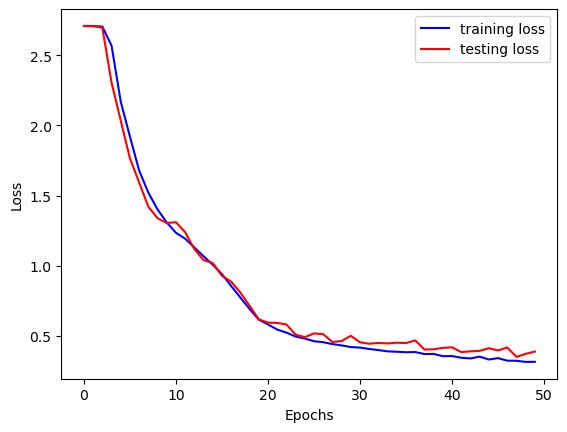

In [34]:
loss_plot(history)

In [37]:
f1_score = F1Score(task = 'multiclass', num_classes = len(class_names))

In [54]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(model, dataloader):
    all_true = []
    all_pred = []
    
    with torch.inference_mode():
        for val_X, val_y in dataloader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_pred = model(val_X)
            
            true_labels = val_y.argmax(dim=1).cpu().detach().numpy()
            predicted_labels = val_pred.argmax(dim=1).cpu().detach().numpy()
            
            all_true.extend(true_labels)
            all_pred.extend(predicted_labels)
    
    return confusion_matrix(all_true, all_pred)

confusion = get_confusion_matrix(model_0, val_dl)
print(confusion)

[[ 98   0   0   0   0   1   0   0   0   2   0   2   0   2   0]
 [  0 113   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   9  68  18   0   1   0   0   0   0   0   0   1   0   0]
 [  0   1  11  92   0   0   0   1   0   0   0   0   0   1   0]
 [  0   0   0   0  90   1   2   4   0   1   0   2   0   2   1]
 [  0   0   1   4   0  79   0   6   0   2   0   2   1   0   0]
 [  0   0   0   0   1   0  87   3   0   4   0   0   2   6   0]
 [  0   0   0   0   0   2   0  84   1   8   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0  98   1   0   0   0   0   0]
 [  0   0   0   0   1   0   0   3   1  75   0   1   0   0   8]
 [  0   1   0   0   1   0   1   1   1   0 107   0   7   2   0]
 [  0   0   0   0   1   1   2   1   0   0   0  70   1  13   0]
 [  0   0   0   0   0   0   1   0   0   0  10   1  92   0   0]
 [  1   0   0   0   0   0   2   0   0   3   1   3   0  75   1]
 [  0   0   0   0   0   2   0   6   1   9   0   2   0   0  72]]


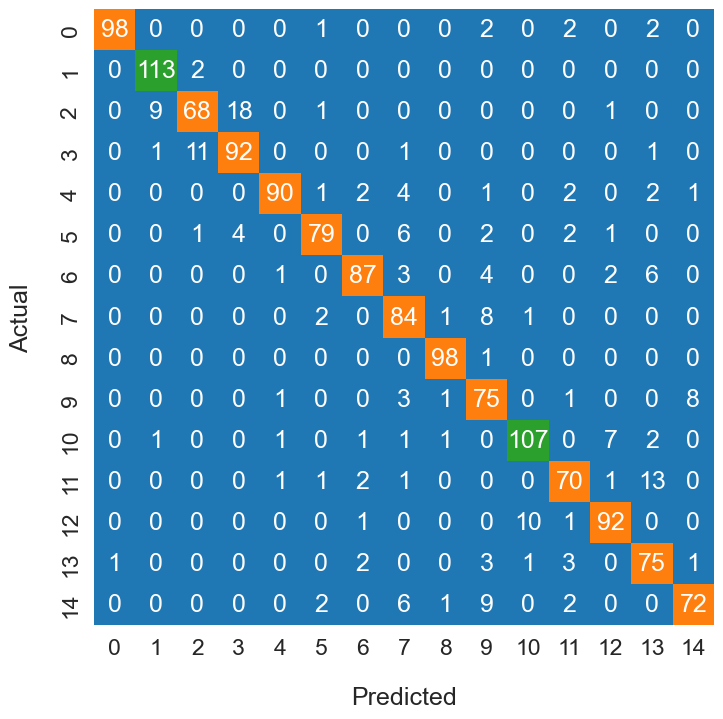

In [57]:
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    confusion, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()

In [58]:
torch.save(model_0, 'chinese_mnist_model_0.pkl')